In [2]:
from dotenv import load_dotenv
load_dotenv()

import os

In [3]:
from comet_ml import Experiment, Optimizer

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.utils.data as data_utils
import pandas as pd
from collections import defaultdict

torch.set_default_dtype(torch.float32)

In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [7]:
from scipy.sparse import coo_matrix
from sklearnex.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, Normalizer

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
DEVICE = 'cpu'

## Load data

In [10]:
VARIABLE = "mental_illness_type_anorexia_nervosa"

In [12]:
data = pd.read_csv("/projects/BINF/Datasets/AGP/agp-full-filtered-rarefied-10000-classified-species-ordered.csv", 
                   encoding = "ISO-8859-1")
data = data.set_index("sample_name").drop("Unnamed: 0", axis=1)

/var/opt/miniconda3/envs/sonata_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
metadata = pd.read_csv("./data/AGP/metadata.csv").set_index("sample_name")

FileNotFoundError: [Errno 2] No such file or directory: './data/AGP/metadata.csv'

In [ ]:
metadata[VARIABLE].value_counts()

In [ ]:
prepped_data = metadata[[VARIABLE]].join(data)
prepped_data = prepped_data[prepped_data[VARIABLE].apply(lambda x: not pd.isna(x))]

### Reduce granularity of categories

In [13]:
reduced_mapping = {
    "Rarely": "Not often",
    "Never": "Not often",
    "Occasionally": "Often",
    "Regularly": "Often",
    "Daily": "Often",
}

In [14]:
prepped_data[VARIABLE] = prepped_data[VARIABLE].apply(lambda x: reduced_mapping[x.split()[0]])
prepped_data[VARIABLE].value_counts()

Not often    8928
Often        8628
Name: alcohol_frequency, dtype: int64

## Get only relevant variables

In [ ]:
result = pyreadr.read_r('/ceph/BINF/PawelLab/SonataBis/data/FS_table.RData')
relevant = result['REL1D'].loc[VARIABLE].fillna(False)
prepped_data = prepped_data.loc[:, prepped_data.columns.str.replace(";",".").isin(list(relevant.index) + [VARIABLE])]

## Split data into training and test

In [15]:
class OTUDataset(torch.utils.data.IterableDataset):
    def __init__(self, data, shuffle: bool=False, samples_no: int=None):
        samples = samples_no or len(data[0])
        self.indices = np.arange(samples)
        if shuffle:
            self.indices = np.random.permutation(self.indices)
        self.index = 0
        self.max_samples = samples
        self.data_x = data[0]
        self.data_y = data[1]

    def __iter__(self):
        while self.index < self.max_samples:
            _idx = self.indices[self.index]
            yield self.data_x[_idx], self.data_y[_idx]
            self.index += 1
    
    def __len__(self):
        return self.data_x.shape[0]

In [16]:
X_data = prepped_data.copy()
del X_data[VARIABLE]

In [17]:
X = torch.from_numpy(X_data.values).to(torch.float32)
X[X.isnan()] = 0

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(prepped_data[VARIABLE].values)
# y = LabelEncoder().fit_transform(metadata.groupby('age_cat').sample(200).values)
y = torch.from_numpy(y).to(torch.int64)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
def get_dataset(size=None, batch_size=32, test_batch_size=32):
    train_dataset = OTUDataset((X_train, y_train), size)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1)
    
    test_dataset = OTUDataset((X_test, y_test), size)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, num_workers=1)
    
    return trainloader, testloader

In [20]:
plt.style.use("seaborn")

## Preprocess data

In [21]:
# "/ceph/BINF/PawelLab/SonataBis"
norm = Normalizer('max')
X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

## Train models

In [152]:
def test_model(model_fn, iters=10):
    results = []

    for i in trange(iters):
        model = model_fn()

        model.fit(X_train, y_train);    
        y_pred = model.predict(X_test)
        for idx, label in enumerate(label_encoder.classes_):
            y_pred_filt = y_pred[y_test==idx]
            y_test_filt = y_test[y_test==idx]
            acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100
            results.append({
                "Class": label,
                "Accuracy": acc
            })

        acc = (y_pred==y_test.numpy()).sum()/len(y_test)*100
        results.append({
            "Class": "Total",
            "Accuracy": acc
        })

    dframe = pd.DataFrame.from_dict(results)
    sns.boxplot(data=dframe, y="Class", x="Accuracy", orient='h')
    return dframe

## Train an XGBoost classifier

In [153]:
from xgboost import XGBClassifier

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.01s/it]


Text(0.5, 1.0, 'XGBoost')

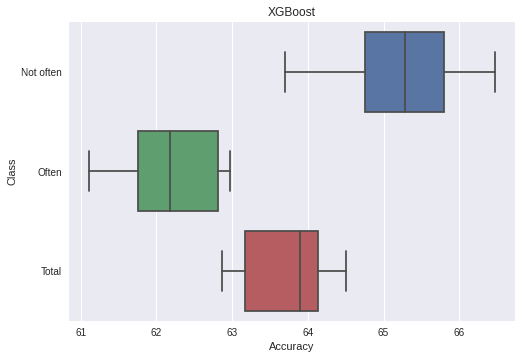

In [154]:
def get_xgboost():
    return XGBClassifier(use_label_encoder=False, 
                         eval_metric='mlogloss', 
                         colsample_bytree=0.3, 
                         random_state=np.random.randint(1024))
xgb_dframe = test_model(get_xgboost)
plt.title("XGBoost")

## Train a random forest classifier

In [155]:
from sklearn.ensemble import RandomForestClassifier

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:41<00:00, 10.17s/it]


Text(0.5, 1.0, 'Random Forest')

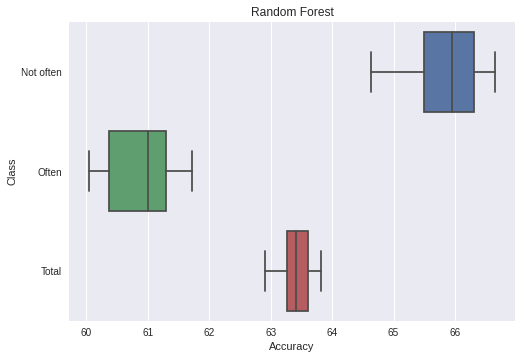

In [156]:
def get_rf():
    return RandomForestClassifier()

rf_dframe = test_model(get_rf)
plt.title("Random Forest")

## Train a network

In [198]:
class AdaptedNetwork:
    def __init__(self, network):
        self.network = network
        self.optimizer = torch.optim.Adam(network.parameters(), lr=3e-5)
        self.criterion = torch.nn.CrossEntropyLoss()
    
    def fit(self, X, y):
        train_dataset = OTUDataset((X, y), X.shape[0])
        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=1)
        
        for epoch in range(150):
            network = self.network.train()
            for i, data in enumerate(trainloader):
                inputs, labels = data
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                self.optimizer.zero_grad()

                outputs = network(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                    
    def predict(self, X):
        res = self.network(torch.from_numpy(X).to(DEVICE)).cpu().detach().numpy()
        res = np.argmax(res, axis=1)
        return res

In [200]:
def get_network(inputs, outputs, l1, l2):
    return torch.nn.Sequential(
    torch.nn.Linear(inputs, l1),
    torch.nn.ReLU(),
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, outputs),
    torch.nn.Sigmoid())

def train_new_network():
    network = get_network(X_train.shape[1], 
                      y.max().item()+1, 
                      256,
                      128).to(DEVICE)
    network = AdaptedNetwork(network)
    return network

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [37:40<00:00, 226.02s/it]


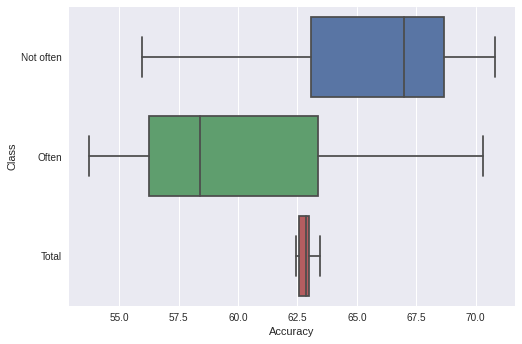

In [201]:
nn_results = test_model(train_new_network)

## Hypernetwork

In [22]:
config = {
    "algorithm": "bayes",
    "parameters": {
        "l1": {"type": "discrete", "values": [128, 256, 512]},
        "l2": {"type": "discrete", "values": [32, 64, 128]},
        "lr": {"type": "discrete", "values": [3e-4, 3e-5, 4e-3, 3e-2]},
    },
    "spec": {
        "metric": "test_loss",
        "objective": "minimize",
    },
}

In [ ]:
mask_size = 100
masks_no = 100
epochs = 200

opt = Optimizer(config, api_key=os.environ.get("COMET_KEY"))
results = []
for experiment in opt.get_experiments(
        project_name="AGP-NN-search"):

    lr = experiment.get_parameter("lr")
    l1 = experiment.get_parameter("l1")
    l2 = experiment.get_parameter("l2")

    hypernet = Hypernetwork(inp_size=X.shape[1], 
                            out_size=y.max().item()+1, 
                            mask_size=mask_size,
                            layers=[l1, l2, 128],
                            node_hidden_size=100, 
                            test_nodes=masks_no).to(DEVICE)

    hypernet = hypernet.train()
    optimizer = torch.optim.Adam(hypernet.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    trainloader, testloader = get_dataset(test_batch_size=32)

    res = train_slow_step(hypernet, optimizer, criterion, 
                          (trainloader, testloader), 
                          X_train.shape[0], 
                          epochs, 
                          masks_no, 
                          test_every=10,
                          experiment=experiment,
                          device=DEVICE)
    results.append([lr, l1, l2, res])

COMET INFO: COMET_OPTIMIZER_ID=8fe3e5b1216e44638ff2b1bb60f1deb6
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 36, 'endTime': None, 'id': '8fe3e5b1216e44638ff2b1bb60f1deb6', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '8fe3e5b1216e44638ff2b1bb60f1deb6', 'parameters': {'l1': {'type': 'discrete', 'values': [128, 256, 512]}, 'l2': {'type': 'discrete', 'values': [32, 64, 128]}, 'lr': {'type': 'discrete', 'values': [0.0003, 3e-05, 0.004, 0.03]}}, 'predictor': None, 'spec': {'gridSize': 10, 'maxCombo': 0, 'metric': 'test_loss', 'minSampleSize': 100, 'objective': 'minimize', 'retryAssignLimit': 0, 'retryLimit': 1000}, 'startTime': 36009485537, 'state': {'mode': None, 'seed': None, 'sequence': [], 'sequence_i': 0, 'sequence_pid': None, 'sequence_retry': 0, 'sequence_retry_count': 0}, 'status': 'running', 'suggestion_count': 0, 'trials': 1, 'version': '2.0.1'}
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ----------

In [28]:
y.max()+1

tensor(2)

## Compare results

<AxesSubplot:xlabel='Accuracy', ylabel='Class'>

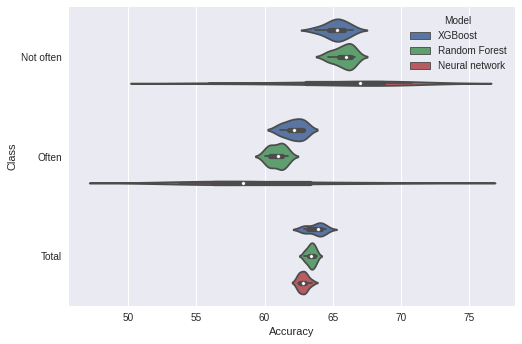

In [202]:
xgb_dframe["Model"] = "XGBoost"
rf_dframe["Model"] = "Random Forest"
nn_results["Model"] = "Neural network"
joined_dframe = pd.concat((xgb_dframe, rf_dframe, nn_results))

sns.violinplot(data=joined_dframe, y="Class", x="Accuracy", hue="Model", orient='h')

In [205]:
joined_dframe.to_csv("model_comparison.csv")